In [1]:
import os
import time
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# Load hyperparameters
with open("../experiments/exp2/config.json", "r") as f:
    config = json.load(f)

original_dir = config["original_dir"]
cartoon_dir = config["cartoon_dir"]
batch_size = config["batch_size"]
total_epochs = config["total_epochs"]
lambda_l1 = config["lambda_l1"]
learning_rate = config["learning_rate"]
limit = config["limit"]
beta1 = config["beta1"]
beta2 = config["beta2"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class CartoonDataset(Dataset):
    def __init__(self, original_dir, cartoon_dir, transform=None, limit=None):
        self.original_paths = sorted(glob(os.path.join(original_dir, '*.png')))
        self.cartoon_paths = sorted(glob(os.path.join(cartoon_dir, '*.png')))
        if limit:
            self.original_paths = self.original_paths[:limit]
            self.cartoon_paths = self.cartoon_paths[:limit]
        self.transform = transform

    def __len__(self):
        return len(self.original_paths)

    def __getitem__(self, idx):
        real = Image.open(self.original_paths[idx]).convert('RGB')
        cartoon = Image.open(self.cartoon_paths[idx]).convert('RGB')
        if self.transform:
            real = self.transform(real)
            cartoon = self.transform(cartoon)
        return real, cartoon


In [5]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU()
        )
        self.middle = nn.Sequential(
            nn.Conv2d(256, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [8]:
dataset = CartoonDataset(original_dir, cartoon_dir, transform=transform, limit=limit)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [11]:
# Instantiate modelsac
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [12]:
# Loss functions
adversarial_loss = nn.BCELoss()
content_loss = nn.L1Loss()

In [13]:
# Optimizers
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [14]:
# for epoch in range(total_epochs):
#     generator.train()
#     discriminator.train()
#     g_epoch_loss = 0
#     d_epoch_loss = 0

#     for real, cartoon in loader:
#         real, cartoon = real.to(device), cartoon.to(device)

#         # Train Discriminator
#         fake = generator(real).detach()
#         d_real = discriminator(cartoon)
#         d_fake = discriminator(fake)

#         real_labels = torch.ones_like(d_real)
#         fake_labels = torch.zeros_like(d_fake)

        

#         d_loss_real = adversarial_loss(d_real, real_labels)
#         d_loss_fake = adversarial_loss(d_fake, fake_labels)
#         d_loss = (d_loss_real + d_loss_fake) * 0.5

#         d_optimizer.zero_grad()
#         d_loss.backward()
#         d_optimizer.step()

#         # Train Generator
#         fake = generator(real)
#         g_adv = adversarial_loss(discriminator(fake), real_labels)
#         g_l1 = content_loss(fake, cartoon)
#         g_loss = g_adv + lambda_l1 * g_l1

#         g_optimizer.zero_grad()
#         g_loss.backward()
#         g_optimizer.step()

#         g_epoch_loss += g_loss.item()
#         d_epoch_loss += d_loss.item()

#     print(f"Epoch {epoch+1}/{total_epochs} | G Loss: {g_epoch_loss/len(loader):.4f} | D Loss: {d_epoch_loss/len(loader):.4f}")

#     # Save checkpoint
#     if (epoch + 1) % 10 == 0:
#         torch.save({
#             'generator': generator.state_dict(),
#             'discriminator': discriminator.state_dict(),
#             'g_optimizer': g_optimizer.state_dict(),
#             'd_optimizer': d_optimizer.state_dict(),
#             'epoch': epoch + 1
#         }, f"cartoongan_epoch{epoch+1}.pth")

In [14]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(g_losses, label="Generator Loss", color='blue')
# plt.plot(d_losses, label="Discriminator Loss", color='red')
# plt.xlabel("Epoch")
# plt.ylabel("Loss")
# plt.title("CartoonGAN Training Loss Over Epochs")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [24]:
g_losses = []
d_losses = []
d_accuracies = []

In [27]:

# if os.path.exists("../losses/losses.json"):
#     with open("../losses/losses.json", "r") as f:
#         losses = json.load(f)
#         g_losses = losses.get("g_losses", [])
#         d_losses = losses.get("d_losses", [])
#         d_accuracies = losses.get("d_accuracies", [])


In [28]:
# # Load from checkpoint
# checkpoint = torch.load("../checkpoints/exp1/cartoongan_epoch150.pth", weights_only=True)

# generator.load_state_dict(checkpoint["generator"])
# discriminator.load_state_dict(checkpoint["discriminator"])
# g_optimizer.load_state_dict(checkpoint["g_optimizer"])
# d_optimizer.load_state_dict(checkpoint["d_optimizer"])
# start_epoch = checkpoint["epoch"]

In [19]:
# Resume training from epoch 100 to 10
for epoch in range(start_epoch, start_epoch + 10):
    start_time = time.time()  
    generator.train()
    discriminator.train()
    g_epoch_loss = 0
    d_epoch_loss = 0
    accuracy_accum = 0
    batch_count = 0
    
    for real, cartoon in loader:
        real, cartoon = real.to(device), cartoon.to(device)

        # Discriminator training
        fake = generator(real).detach()
        d_real = discriminator(cartoon)
        d_fake = discriminator(fake)

        real_labels = torch.ones_like(d_real)
        fake_labels = torch.zeros_like(d_fake)

        d_loss_real = adversarial_loss(d_real, real_labels)
        d_loss_fake = adversarial_loss(d_fake, fake_labels)
        d_loss = (d_loss_real + d_loss_fake) * 0.5

        # Accuracy tracking
        pred_real = (d_real > 0.5).float()
        pred_fake = (d_fake < 0.5).float()
        correct_real = pred_real.eq(real_labels).sum().item()
        correct_fake = pred_fake.eq(fake_labels).sum().item()
        total = real_labels.numel() + fake_labels.numel()
        batch_accuracy = (correct_real + correct_fake) / total
        accuracy_accum += batch_accuracy
        batch_count += 1

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator training
        fake = generator(real)
        g_adv = adversarial_loss(discriminator(fake), real_labels)
        g_l1 = content_loss(fake, cartoon)
        g_loss = g_adv + lambda_l1 * g_l1

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        g_epoch_loss += g_loss.item()
        d_epoch_loss += d_loss.item()
        
        
    end_time = time.time()  # ⏱️ End timer
    epoch_time = end_time - start_time
    epoch_accuracy = accuracy_accum / batch_count
    
    g_losses.append(g_epoch_loss / len(loader))
    d_losses.append(d_epoch_loss / len(loader))
    d_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1} | G Loss: {g_epoch_loss/len(loader):.4f} | D Loss: {d_epoch_loss/len(loader):.4f} | Acc: {epoch_accuracy:.4f} | Time: {epoch_time:.2f}s")

    generator.eval()
    discriminator.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for real, cartoon in loader:
            real, cartoon = real.to(device), cartoon.to(device)
    
            d_real = discriminator(cartoon)
            d_fake = discriminator(generator(real))
    
            labels_real = torch.ones_like(d_real).cpu().numpy()
            labels_fake = torch.zeros_like(d_fake).cpu().numpy()
    
            preds_real = (d_real > 0.5).float().cpu().numpy()
            preds_fake = (d_fake > 0.5).float().cpu().numpy()
    
            all_labels.extend(labels_real.flatten())
            all_labels.extend(labels_fake.flatten())
            all_preds.extend(preds_real.flatten())
            all_preds.extend(preds_fake.flatten())

  # Save model and losses every epoch
    with open("../experiments/exp1/losses/losses.json", "w") as f:
        json.dump({"g_losses": g_losses, "d_losses": d_losses,  "d_accuracies": d_accuracies}, f)
     # Save every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'g_optimizer': g_optimizer.state_dict(),
            'd_optimizer': d_optimizer.state_dict(),
            'epoch': epoch + 1
        }, f"../outputs/exp1/cartoongan_epoch{epoch+1}.pth")




Epoch 151 | G Loss: 11.9587 | D Loss: 0.3683 | Acc: 0.4918 | Time: 35.50s
Epoch 152 | G Loss: 12.0094 | D Loss: 0.3899 | Acc: 0.4878 | Time: 32.27s
Epoch 153 | G Loss: 12.1896 | D Loss: 0.4393 | Acc: 0.4927 | Time: 32.11s
Epoch 154 | G Loss: 11.6387 | D Loss: 0.4193 | Acc: 0.4858 | Time: 32.33s
Epoch 155 | G Loss: 11.9140 | D Loss: 0.3825 | Acc: 0.4913 | Time: 32.73s
Epoch 156 | G Loss: 11.9370 | D Loss: 0.3885 | Acc: 0.4904 | Time: 32.55s
Epoch 157 | G Loss: 11.8436 | D Loss: 0.4219 | Acc: 0.4948 | Time: 32.85s
Epoch 158 | G Loss: 11.6926 | D Loss: 0.4221 | Acc: 0.4915 | Time: 33.81s
Epoch 159 | G Loss: 11.5236 | D Loss: 0.4049 | Acc: 0.4904 | Time: 33.25s
Epoch 160 | G Loss: 11.4855 | D Loss: 0.4282 | Acc: 0.4889 | Time: 33.84s


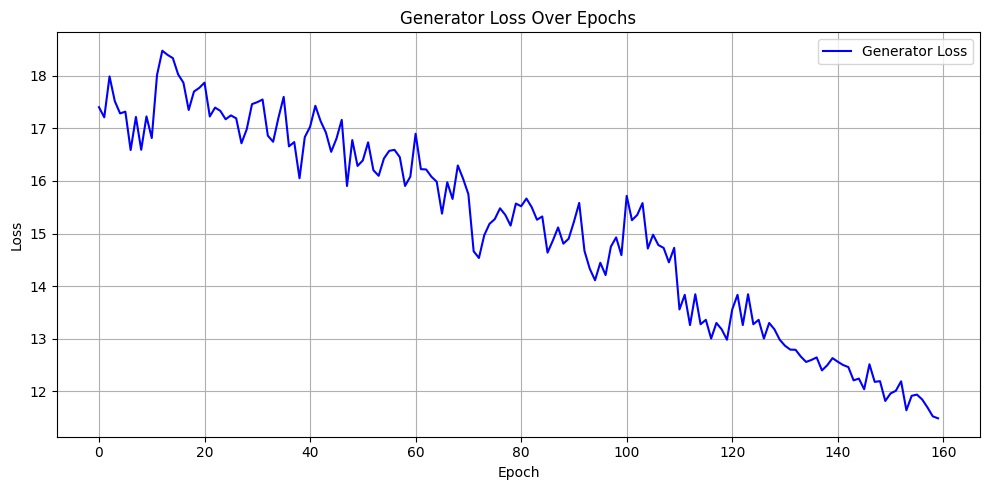

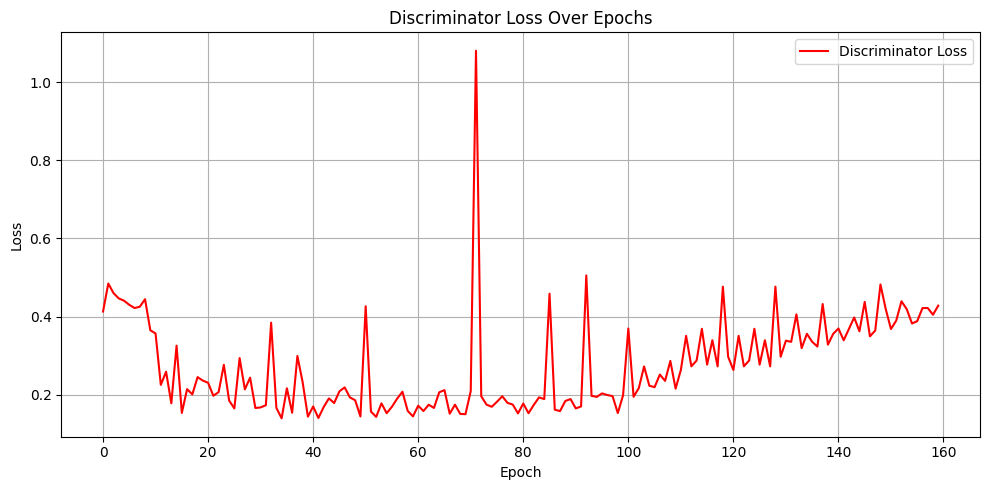

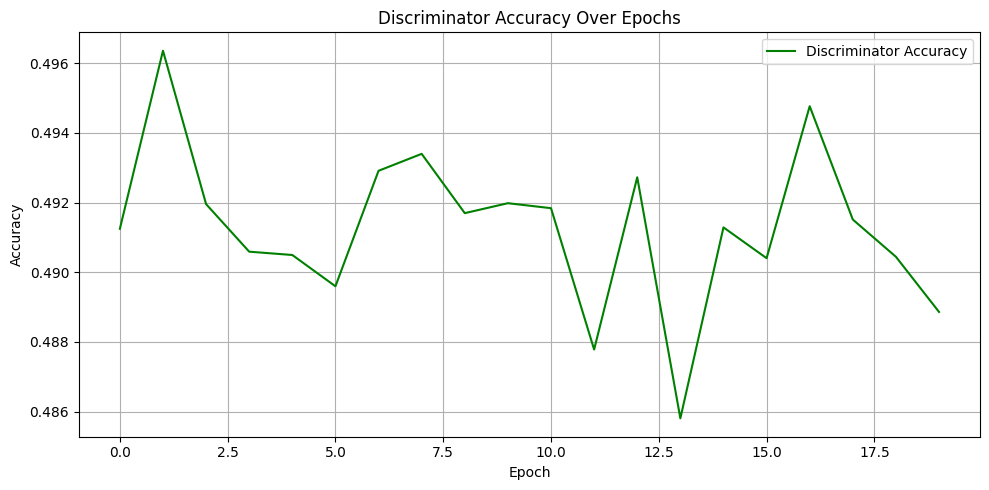

In [29]:
import matplotlib.pyplot as plt

# Plot Generator Loss
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Discriminator Loss
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Discriminator Loss Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(d_accuracies, label="Discriminator Accuracy", color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Discriminator Accuracy Over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [34]:

print(f"Total training samples: {len(dataset)}")


Total training samples: 1500


In [30]:
print(g_losses)


[17.4024, 17.2096, 17.9875, 17.5168, 17.284, 17.3171, 16.5874, 17.2166, 16.593, 17.2267, 16.816, 18.0136, 18.4762, 18.3965, 18.3351, 18.0261, 17.8686, 17.3496, 17.6997, 17.769, 17.8691, 17.2256, 17.3945, 17.332, 17.1726, 17.2462, 17.19, 16.7162, 16.9831, 17.4608, 17.498, 17.5481, 16.8603, 16.7448, 17.1977, 17.5985, 16.6573, 16.7389, 16.0511, 16.8333, 17.0288, 17.4285, 17.1366, 16.9206, 16.5535, 16.8038, 17.1611, 15.9038, 16.7769, 16.2849, 16.391, 16.7335, 16.2044, 16.0977, 16.4273, 16.5723, 16.5907, 16.4531, 15.9047, 16.0825, 16.8971, 16.2241, 16.2181, 16.0797, 15.9848, 15.3787, 15.9741, 15.6574, 16.2939, 16.0414, 15.7478, 14.6623, 14.5348, 14.9659, 15.1836, 15.2737, 15.4797, 15.3531, 15.1509, 15.5696, 15.5185, 15.6651, 15.5008, 15.2621, 15.3244, 14.6369, 14.8643, 15.1155, 14.8071, 14.901, 15.2233, 15.5818, 14.6687, 14.3306, 14.1117, 14.4436, 14.2099, 14.7501, 14.926, 14.5885, 15.7156, 15.2532, 15.354, 15.5783, 14.7147, 14.9774, 14.7809, 14.7261, 14.4519, 14.7281, 13.5566, 13.834, 13.2